# New pre-process with quadratic trend

In [1]:

def add_decimal_year(da, dim='time'):
    """
    Calculate decimal year from datetime coordinate and add as a new coordinate.
    
    Parameters
    ----------
    da : xarray.DataArray
        Input data array with datetime coordinate named 'time'
    
    Returns
    -------
    da : xarray.DataArray
        Input data array with 'decimal_year' coordinate added
    """
    
    time = pd.to_datetime(da[dim])
    start_of_year = pd.to_datetime(time.year.astype(str) + '-01-01')
    start_of_next_year = pd.to_datetime((time.year + 1).astype(str) + '-01-01')
    year_elapsed = (time - start_of_year).days
    year_duration = (start_of_next_year - start_of_year).days
    
    decimal_year = time.year + year_elapsed / year_duration

    da = da.assign_coords(decimal_year=(dim, decimal_year))
    
    return da


def rechunk_for_cohorts(da, chunksize=100, dim='time'):
    """
    Rechunk data array for efficient climatology & day-of-year STD reductions.
    
    Parameters
    ----------
    da : xarray.DataArray
        Input data array
    chunksize : int, optional
        Chunk size for rechunking
        
    Returns
    -------
    xarray.DataArray
        Rechunked data array
    """
    
    da = flox.xarray.rechunk_for_cohorts(da, 
                                         dim=dim, 
                                         labels=da[dim].dt.dayofyear, 
                                         force_new_chunk_at=1, 
                                         chunksize=chunksize, 
                                         ignore_old_chunks=True)
    
    return da


    
def compute_normalised_anomaly(da, std_normalise=False, dask_chunks={'time': 25}, dimensions={'time':'time', 'xdim':'lon', 'ydim':'lat'}):
    """
    Standardise data by:
    1. Removing trend and seasonal cycle using an 8-coefficient model (mean, linear & quadratic trend, annual & semi-annual harmonics)
    2. Dividing by 30-day rolling standard deviation
    """
    
    # Ensure the time dimension is the first dimension
    if da.dims[0] != dimensions['time']:
        da = da.transpose(dimensions['time'], ...)
    
    # Add decimal year coordinate to data array
    da = add_decimal_year(da)
    
    # Construct model for detrending (now includes quadratic trend)
    model = np.array([
        np.ones(len(da.decimal_year)),
        da.decimal_year - np.mean(da.decimal_year),
        (da.decimal_year - np.mean(da.decimal_year))**2,  # quadratic term
        np.sin(2 * np.pi * da.decimal_year),
        np.cos(2 * np.pi * da.decimal_year),
        np.sin(4 * np.pi * da.decimal_year),
        np.cos(4 * np.pi * da.decimal_year)
    ])
    
    # Take pseudo-inverse of model
    pmodel = np.linalg.pinv(model)
    
    # Convert to xarray DataArrays
    model_da = xr.DataArray(
        model.T, 
        dims=[dimensions['time'],'coeff'], 
        coords={dimensions['time']: da[dimensions['time']].values, 'coeff': np.arange(1,8,1)}
    ).chunk({dimensions['time']: da.chunks[0]})
    
    pmodel_da = xr.DataArray(
        pmodel.T,
        dims=['coeff',dimensions['time']],
        coords={'coeff': np.arange(1,8,1), dimensions['time']: da[dimensions['time']].values}
    )
    
    # Calculate model coefficients
    model_fit_da = xr.DataArray(
        pmodel_da.dot(da),
        dims=['coeff',dimensions['ydim'],dimensions['xdim']],
        coords={
            'coeff': np.arange(1,8,1),
            dimensions['ydim']: da[dimensions['ydim']].values,
            dimensions['xdim']: da[dimensions['xdim']].values
        }
    )
    
    # Remove trend and seasonal cycle
    da_detrend = (da - model_da.dot(model_fit_da))
    
    # Rechunk the data
    da_detrend = da_detrend.chunk({'time':dask_chunks['time'], dimensions['ydim']:-1, dimensions['xdim']:-1})
    
    # Create mask from first timestep
    mask = np.isfinite(da.isel({dimensions['time']:0})).chunk({dimensions['ydim']:-1, dimensions['xdim']:-1}).drop_vars({'decimal_year', 'time'})
    
    data_vars = {
        'dat_detrend': da_detrend.drop_vars({'decimal_year'}),
        'mask': mask
    }    
    
    ## Standardise Data Anomalies
    if std_normalise: 
        # Calculate daily standard deviation
        std_day = flox.xarray.xarray_reduce(
            da_detrend,
            da_detrend[dimensions['time']].dt.dayofyear,
            dim=dimensions['time'],
            func='std',
            isbin=False,
            method='cohorts'
        )
        
        # Calculate 30-day rolling standard deviation
        std_day_wrap = std_day.pad(dayofyear=16, mode='wrap')
        std_rolling = np.sqrt(
            (std_day_wrap**2)
            .rolling(dayofyear=30, center=True)
            .mean()
        ).isel(dayofyear=slice(16,366+16))
        
        # STD Normalised anomalies
        da_stn = da_detrend.groupby(da_detrend[dimensions['time']].dt.dayofyear) / std_rolling
        
        # Rechunk the data
        da_stn = da_stn.chunk({'time':dask_chunks['time'], dimensions['ydim']:-1, dimensions['xdim']:-1})
        std_rolling = std_rolling.chunk({'dayofyear':-1, dimensions['ydim']:-1, dimensions['xdim']:-1})
        
        data_vars['dat_stn'] = da_stn.drop_vars({'dayofyear', 'decimal_year'})
        data_vars['STD'] = std_rolling
    
    return xr.Dataset(
        data_vars=data_vars,
        attrs={
            'description': 'Standardised & Detrended Data (including quadratic trend removal)',
            'preprocessing_steps': [
                'Removed quadratic, linear trend & seasonal cycle',
                'Normalise by 30-day rolling STD'
            ]
        }
    )


# Code to look at every component of the de-trending
## e.g. linear trend, harmonics,..

In [2]:

def add_decimal_year(da, dim='time'):
    """
    Calculate decimal year from datetime coordinate and add as a new coordinate.
    
    Parameters
    ----------
    da : xarray.DataArray
        Input data array with datetime coordinate named 'time'
    
    Returns
    -------
    da : xarray.DataArray
        Input data array with 'decimal_year' coordinate added
    """
    
    time = pd.to_datetime(da[dim])
    start_of_year = pd.to_datetime(time.year.astype(str) + '-01-01')
    start_of_next_year = pd.to_datetime((time.year + 1).astype(str) + '-01-01')
    year_elapsed = (time - start_of_year).days
    year_duration = (start_of_next_year - start_of_year).days
    
    decimal_year = time.year + year_elapsed / year_duration

    da = da.assign_coords(decimal_year=(dim, decimal_year))
    
    return da


def rechunk_for_cohorts(da, chunksize=100, dim='time'):
    """
    Rechunk data array for efficient climatology & day-of-year STD reductions.
    
    Parameters
    ----------
    da : xarray.DataArray
        Input data array
    chunksize : int, optional
        Chunk size for rechunking
        
    Returns
    -------
    xarray.DataArray
        Rechunked data array
    """
    
    da = flox.xarray.rechunk_for_cohorts(da, 
                                         dim=dim, 
                                         labels=da[dim].dt.dayofyear, 
                                         force_new_chunk_at=1, 
                                         chunksize=chunksize, 
                                         ignore_old_chunks=True)
    
    return da


    
def components(da, std_normalise=False, dask_chunks={'time': 150}, dimensions={'time':'time', 'xdim':'lon', 'ydim':'lat'}):
    """
    Standardise data by:
    1. Removing trend and seasonal cycle using an 8-coefficient model (mean, linear & quadratic trend, annual & semi-annual harmonics)
    2. Dividing by 30-day rolling standard deviation
    """
    
    # Ensure the time dimension is the first dimension
    if da.dims[0] != dimensions['time']:
        da = da.transpose(dimensions['time'], ...)
    
    # Add decimal year coordinate to data array
    da = add_decimal_year(da)
    
    # Construct model for detrending (now includes quadratic trend)
    model = np.array([
        np.ones(len(da.decimal_year)),
        da.decimal_year - np.mean(da.decimal_year),
        (da.decimal_year - np.mean(da.decimal_year))**2,  # quadratic term
        np.sin(2 * np.pi * da.decimal_year),
        np.cos(2 * np.pi * da.decimal_year),
        np.sin(4 * np.pi * da.decimal_year),
        np.cos(4 * np.pi * da.decimal_year)
    ])
    
    # Take pseudo-inverse of model
    pmodel = np.linalg.pinv(model)
    
    # Convert to xarray DataArrays
    model_da = xr.DataArray(
        model.T, 
        dims=[dimensions['time'],'coeff'], 
        coords={dimensions['time']: da[dimensions['time']].values, 'coeff': np.arange(1,8,1)}
    ).chunk({dimensions['time']: da.chunks[0]})
    
    pmodel_da = xr.DataArray(
        pmodel.T,
        dims=['coeff',dimensions['time']],
        coords={'coeff': np.arange(1,8,1), dimensions['time']: da[dimensions['time']].values}
    )
    
    # Calculate model coefficients
    model_fit_da = xr.DataArray(
        pmodel_da.dot(da),
        dims=['coeff',dimensions['ydim'],dimensions['xdim']],
        coords={
            'coeff': np.arange(1,8,1),
            dimensions['ydim']: da[dimensions['ydim']].values,
            dimensions['xdim']: da[dimensions['xdim']].values
        }
    )
    components = {
        'mean': model_da.sel(coeff=1) * model_fit_da.sel(coeff=1),
        'linear_trend': model_da.sel(coeff=2) * model_fit_da.sel(coeff=2),
        'quadratic_trend': model_da.sel(coeff=3) * model_fit_da.sel(coeff=3),
        'annual_sin': model_da.sel(coeff=4) * model_fit_da.sel(coeff=4),
        'annual_cos': model_da.sel(coeff=5) * model_fit_da.sel(coeff=5),
        'semi_annual_sin': model_da.sel(coeff=6) * model_fit_da.sel(coeff=6),
        'semi_annual_cos': model_da.sel(coeff=7) * model_fit_da.sel(coeff=7)
    }
    
    # Remove trend and seasonal cycle
    da_detrend = (da - model_da.dot(model_fit_da))
    
    # Rechunk the data
    da_detrend = da_detrend.chunk({'time':dask_chunks['time'], dimensions['ydim']:-1, dimensions['xdim']:-1})
    
    # Create mask from first timestep
    mask = np.isfinite(da.isel({dimensions['time']:0})).chunk({dimensions['ydim']:-1, dimensions['xdim']:-1}).drop_vars({'decimal_year', 'time'})
    
    data_vars = {
        'dat_detrend': da_detrend.drop_vars({'decimal_year'}),
        'mask': mask,
        **{k: v.drop_vars('coeff') for k, v in components.items()}  # Add all components
    }   
    
    ## Standardise Data Anomalies
    if std_normalise: 
        # Calculate daily standard deviation
        std_day = flox.xarray.xarray_reduce(
            da_detrend,
            da_detrend[dimensions['time']].dt.dayofyear,
            dim=dimensions['time'],
            func='std',
            isbin=False,
            method='cohorts'
        )
        
        # Calculate 30-day rolling standard deviation
        std_day_wrap = std_day.pad(dayofyear=16, mode='wrap')
        std_rolling = np.sqrt(
            (std_day_wrap**2)
            .rolling(dayofyear=30, center=True)
            .mean()
        ).isel(dayofyear=slice(16,366+16))
        
        # STD Normalised anomalies
        da_stn = da_detrend.groupby(da_detrend[dimensions['time']].dt.dayofyear) / std_rolling
        
        # Rechunk the data
        da_stn = da_stn.chunk({'time':dask_chunks['time'], dimensions['ydim']:-1, dimensions['xdim']:-1})
        std_rolling = std_rolling.chunk({'dayofyear':-1, dimensions['ydim']:-1, dimensions['xdim']:-1})
        
        data_vars['dat_stn'] = da_stn.drop_vars({'dayofyear', 'decimal_year'})
        data_vars['STD'] = std_rolling
    
    return xr.Dataset(
        data_vars=data_vars,
        attrs={
            'description': 'Standardised & Detrended Data (including quadratic trend removal)',
            'preprocessing_steps': [
                'Removed quadratic, linear trend & seasonal cycle',
                'Normalise by 30-day rolling STD'
            ]
        }
    )


# Run

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import dask
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import intake
import cartopy.crs as ccrs
from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
from dask.distributed import Client, LocalCluster
import subprocess
import re

import warnings
warnings.filterwarnings('ignore')

In [4]:

import dask
from dask.distributed import Client, LocalCluster
import bokeh
#THIS MAKES DASK SPILL TO SCRATCH INSTEAD OF /tmp/dask-scratch-space which was the default,
#and didnt have enough space
cluster_scratch = Path('/scratch') / getuser()[0] / getuser() / 'clients'
dask_tmp_dir = TemporaryDirectory(dir=cluster_scratch)
dask.config.set(temporary_directory=dask_tmp_dir.name)
dask.config.set({'array.slicing.split_large_chunks': False})

dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
cluster = LocalCluster(n_workers=32, threads_per_worker=4)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/b382616/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/b382616/levante-spawner-preset//proxy/8787/status,Workers: 32
Total threads: 128,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39933,Workers: 32
Dashboard: /user/b382616/levante-spawner-preset//proxy/8787/status,Total threads: 128
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:41175,Total threads: 4
Dashboard: /user/b382616/levante-spawner-preset//proxy/37025/status,Memory: 7.36 GiB
Nanny: tcp://127.0.0.1:36495,


In [58]:
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

dat = cat['dkrz.disk.observations.OSTIA.OSTIA.daily']#-output'][model][expid][version]['ocean'][gridspec]
sst = dat(chunks={}).to_dask()


In [7]:
sst=sst-273.15 #to celsius

In [8]:
sst_gr=sst['sst'].coarsen(lat=5, lon=5,boundary='pad').mean()
sst_gr=sst_gr.isel(time=slice(0,13879))

In [9]:
sst_gr = sst_gr.chunk({'time':200})

In [10]:
sst_gr=sst_gr.persist()

In [11]:
ssta=compute_normalised_anomaly(sst_gr)['dat_detrend']

In [57]:
sst

<xarray.Dataset> Size: 11TB
Dimensions:         (lat: 3600, lon: 7200, time: 14761)
Coordinates:
  * lat             (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon             (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time            (time) datetime64[ns] 118kB 1982-01-01T12:00:00 ... 2022-...
Data variables:
    analysis_error  (time, lat, lon) float64 3TB dask.array<chunksize=(10, 1200, 1800), meta=np.ndarray>
    mask            (time, lat, lon) float32 2TB dask.array<chunksize=(10, 1200, 1800), meta=np.ndarray>
    siconc          (time, lat, lon) float64 3TB dask.array<chunksize=(10, 1200, 1800), meta=np.ndarray>
    sst             (time, lat, lon) float64 3TB dask.array<chunksize=(10, 1200, 1800), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.4, ACDD-1.3
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    WARNING Some applications are unable to prope...
    creator_email:              servicedesk.cmems@mercator-ocean.eu
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    time_coverage_end:          20220601T000000Z
    time_coverage_start:        20220531T000000Z
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    uuid:                       a2df4a18-6f19-4772-9532-39307a0e2794
    westernmost_longitude:      -180.0

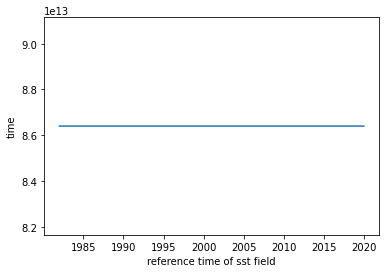

In [59]:
sst_gr.time.diff(dim='time').plot()

In [65]:
# Import 40 years of Daily EERIE ICON data

cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
expid = 'eerie-control-1950'
version = 'v20231106'
model = 'icon-esm-er'
gridspec = 'gr025'

dat = cat['dkrz.disk.model-output'][model][expid][version]['ocean'][gridspec]


# Load the data directly into optimal chunks

da_predictor = dat['2d_daily_mean'](chunks={}).to_dask().to.isel(depth=0).drop_vars('depth') # Test da
#time_chunk = hot.rechunk_for_cohorts(da_predictor).chunks[0]

sst_ic = dat['2d_daily_mean'](chunks={'time':150}).to_dask().to.isel(depth=0).drop_vars('depth')

In [79]:
lin_space=ds_components['linear_trend'].mean(dim={'lat','lon'})

In [80]:
lin_space=lin_space.compute()

In [82]:
lin_space.mean()

<xarray.DataArray 'linear_trend' ()> Size: 8B
array(-3.19460096e-16)

In [70]:
temp_ic=add_decimal_year(sst_ic)
temp=add_decimal_year(sst_gr)

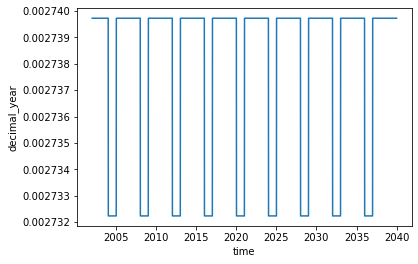

In [72]:
temp_ic.decimal_year.diff(dim='time').plot()

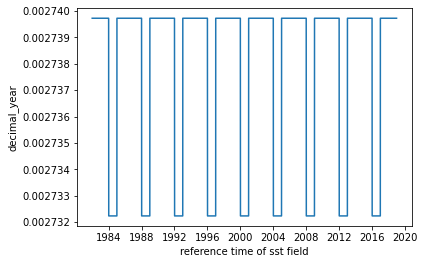

In [83]:
temp.decimal_year.diff(dim='time').isel(time=slice(0,365*37)).plot()

In [87]:
linsp_ic=ic_comp['linear_trend'].mean(dim={'lat','lon'})

In [88]:
linsp_ic=linsp_ic.compute()

2025-02-27 17:29:58,810 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 6.22 GiB -- Worker memory limit: 7.36 GiB
2025-02-27 17:29:59,324 - distributed.worker.memory - WARNING - Worker is at 54% memory usage. Resuming worker. Process memory: 3.98 GiB -- Worker memory limit: 7.36 GiB


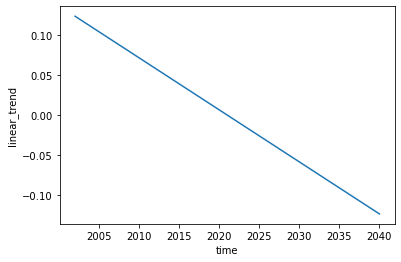

In [89]:
linsp_ic.plot()

In [99]:
value=((sst_gr-mean)*temp.decimal_year.diff(dim='time')).mean()

In [102]:
value=value.compute()

In [105]:
mean_ic=ic_comp['mean']

In [108]:
(sst_ic.mean()-mean_ic.mean()).compute()

<xarray.DataArray ()> Size: 8B
array(-0.00499634)

In [98]:
(sst_gr-mean).mean().compute()

<xarray.DataArray ()> Size: 8B
array(0.01983691)

In [12]:
ssta_mean=ssta.mean(dim='time')
ssta_mean=ssta_mean.persist()


In [13]:
ssta_mean=ssta_mean.compute()

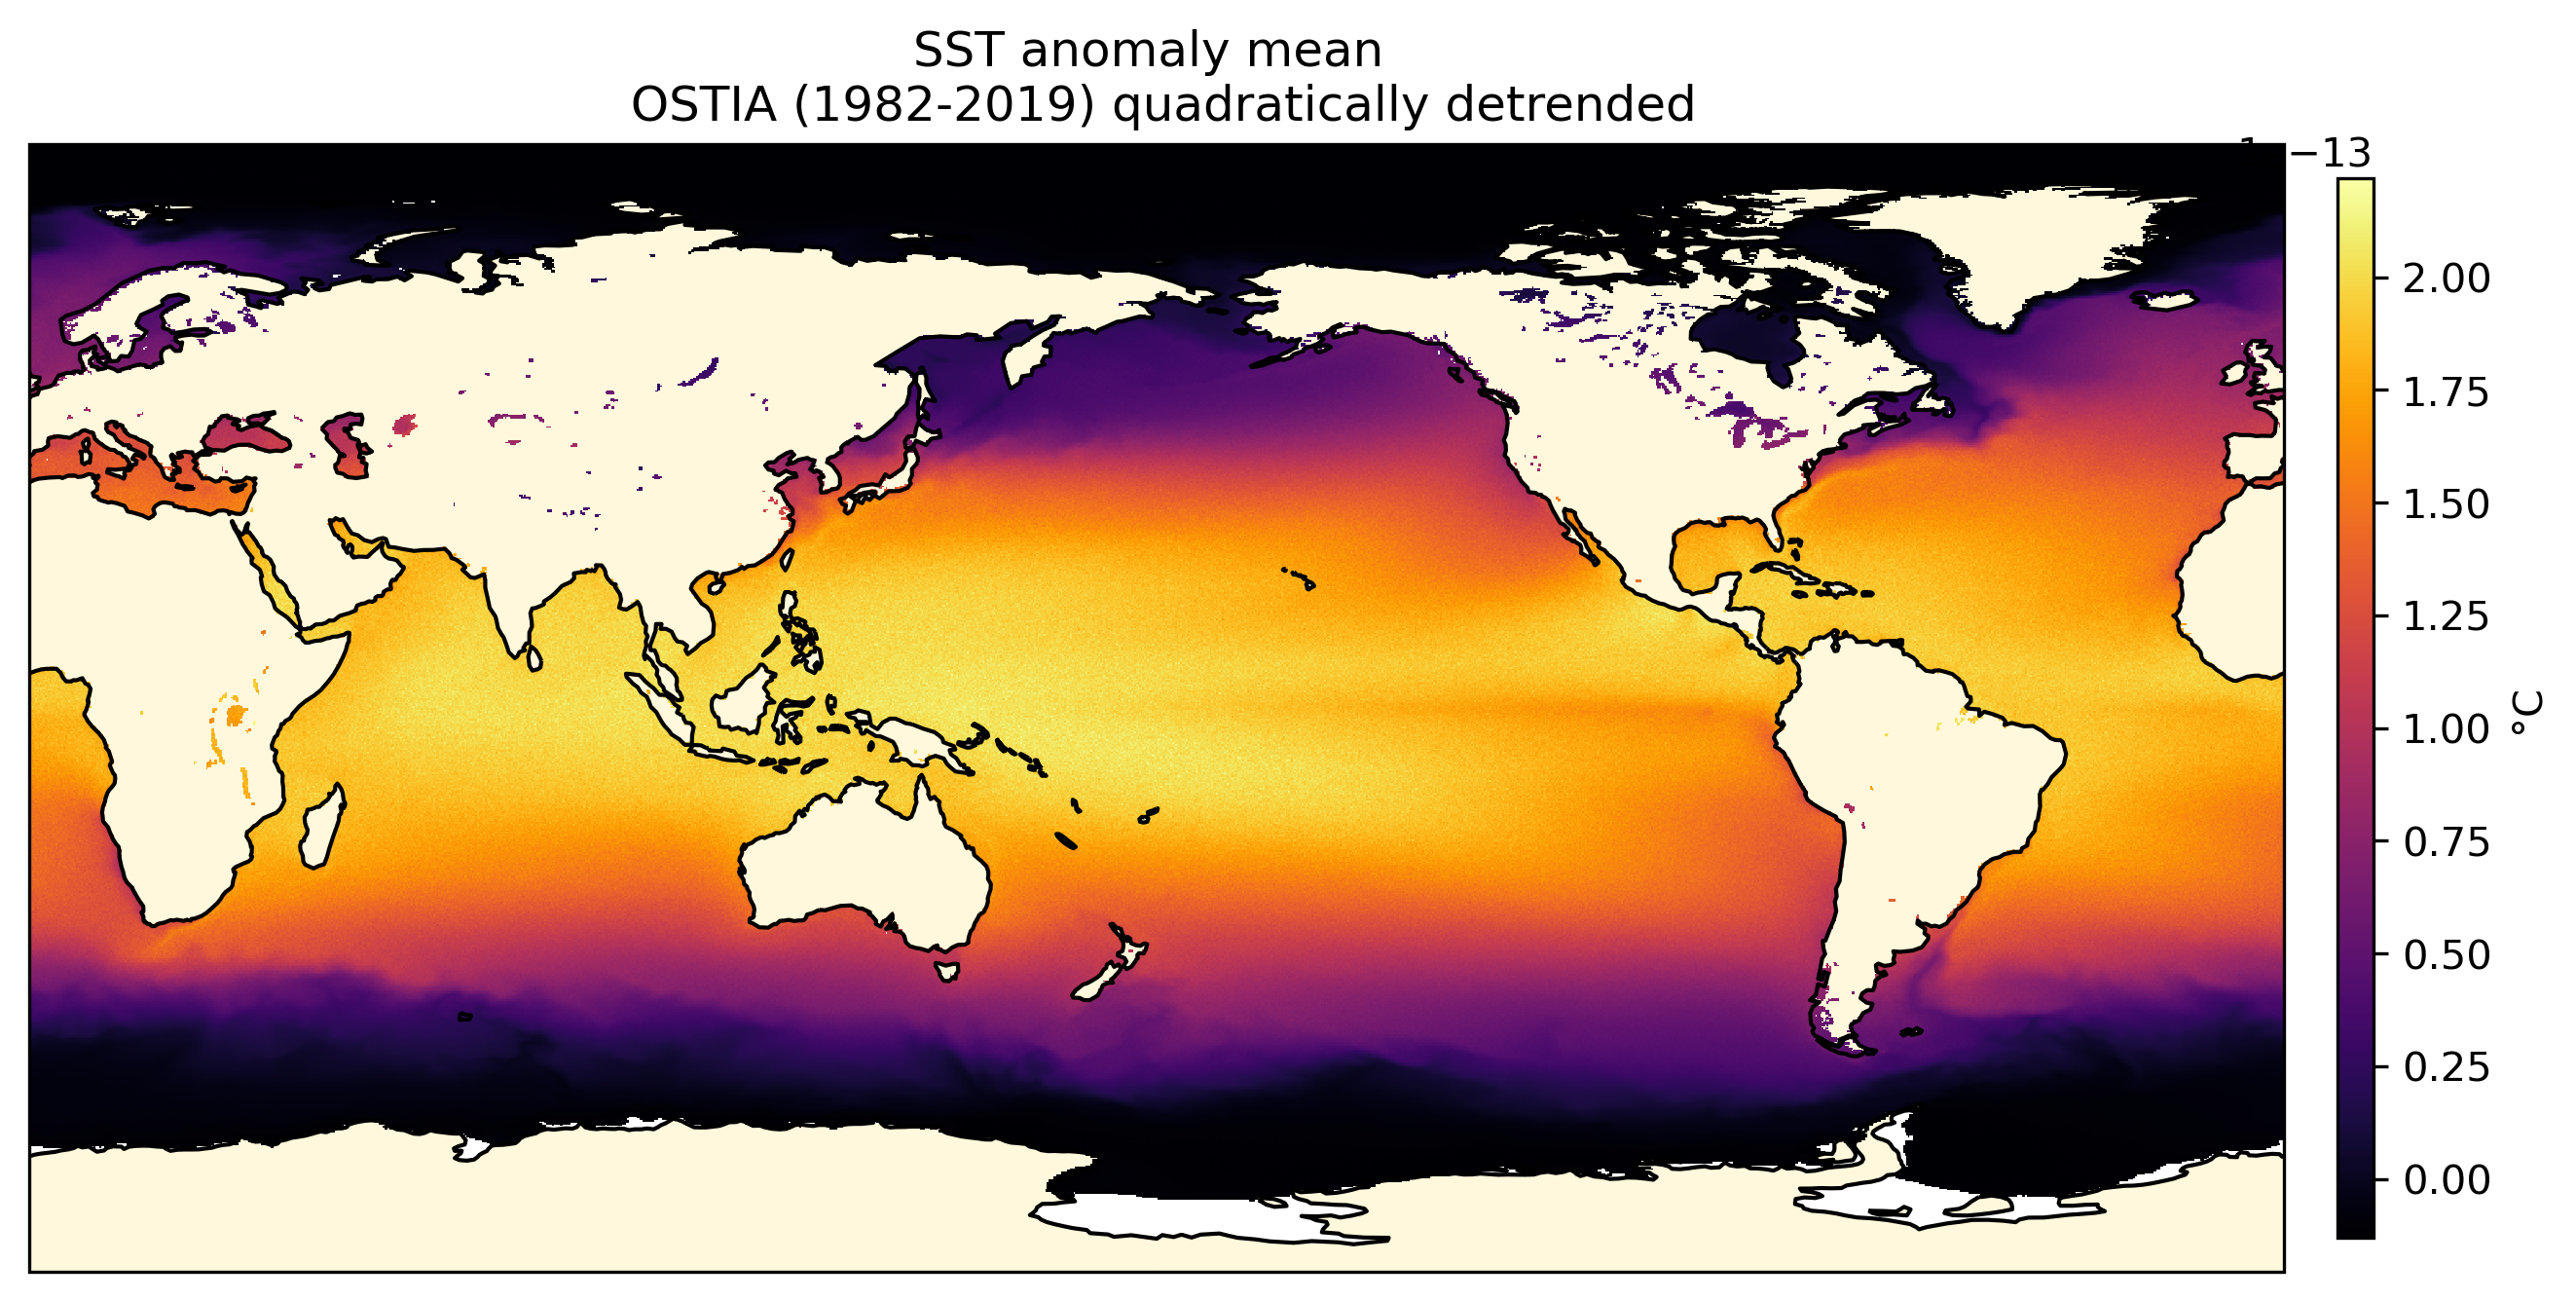

In [14]:
fig = plt.figure(figsize=(12, 6),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')

ax.coastlines()
pcm = ax.pcolormesh(ssta_mean.lon, ssta_mean.lat, ssta_mean, cmap='inferno',transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=10))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST anomaly mean \n OSTIA (1982-2019) quadratically detrended")

plt.show()


# plot components

In [84]:

ds_components = components(sst_gr)

In [17]:
sst_mean=sst_gr.mean(dim='time')

In [18]:
sst_mean=sst_mean.compute()

In [85]:
ic_comp=components(sst_ic)

In [19]:
lin=ds_components['linear_trend'].mean(dim='time').persist()

In [20]:
lin=lin.compute()

In [ ]:
lin=ds_components['linear_trend'].mean(dim='time').persist()
wait(lin)
quad=ds_components['quadratic_trend'].mean(dim='time').persist()
wait(quad)
mean=ds_components['mean'].mean(dim='time').persist()
wait(mean)
ann_sin=ds_components['annual_sin'].mean(dim='time').persist()
wait(ann_sin)
ann_cos=ds_components['annual_cos'].mean(dim='time').persist()
wait(ann_cos)
semi_sin=ds_components['semi_annual_sin'].mean(dim='time').persist()
wait(semi_sin)
semi_cos=ds_components['semi_annual_cos'].mean(dim='time').persist()
wait(semi_cos)

2025-02-27 14:44:39,013 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-sst-167d0dca1a6a0bcb7e8d90cae040cb8b' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: memory
old run_spec: (<function execute_task at 0x7fff0e8abaf0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7ffd16dadd40>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x7fff

In [23]:
quad=ds_components['quadratic_trend'].mean(dim='time').persist()

In [24]:
quad=quad.compute()

In [21]:
mean=ds_components['mean'].mean(dim='time').persist()
mean=mean.compute()

In [29]:
ann_sin=ds_components['annual_sin'].mean(dim='time').persist()
ann_sin=ann_sin.compute()

In [32]:
ann_cos=ds_components['annual_cos'].mean(dim='time').persist()
ann_cos=ann_cos.compute()

In [40]:
semi_sin=ds_components['semi_annual_sin'].mean(dim='time').persist()
semi_sin=semi_sin.compute()
semi_cos=ds_components['semi_annual_cos'].mean(dim='time').persist()
semi_cos=semi_cos.compute()

In [50]:
quad.mean()

<xarray.DataArray 'quadratic_trend' ()> Size: 8B
array(0.01983691)

In [51]:
mean.mean()

<xarray.DataArray 'mean' ()> Size: 8B
array(13.58674872)

In [52]:
sst_mean.mean()

<xarray.DataArray 'sst' ()> Size: 8B
array(13.60658563)

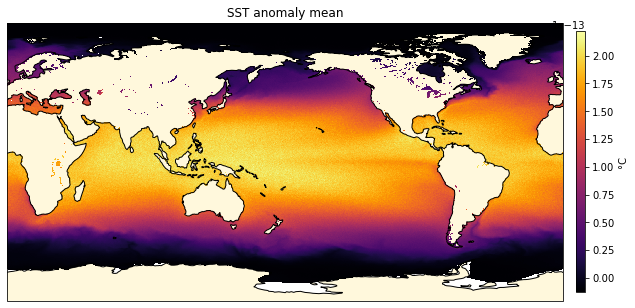

In [53]:
var=ssta_mean

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')
cmap = plt.get_cmap('PiYG', 11)  
ax.coastlines()
pcm = ax.pcolormesh(var.lon, var.lat, var, cmap='inferno',transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=10))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST anomaly mean")

plt.show()


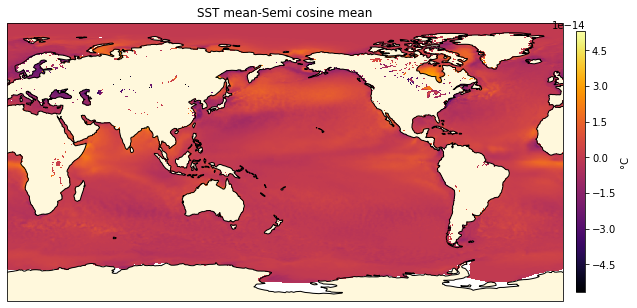

In [46]:
var=semi_cos

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')
cmap = plt.get_cmap('PiYG', 11)  
ax.coastlines()
pcm = ax.pcolormesh(var.lon, var.lat, var, cmap='inferno',transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=10))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST mean-Semi cosine mean")

plt.show()


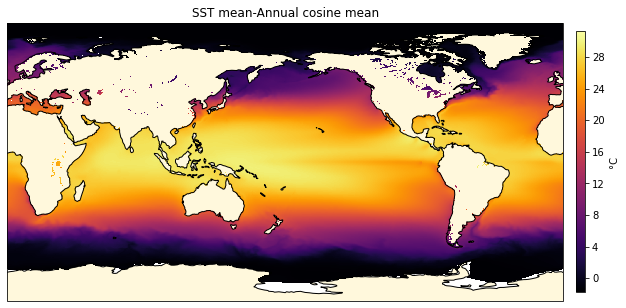

In [33]:
var=sst_mean-ann_cos

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')
cmap = plt.get_cmap('PiYG', 11)  
ax.coastlines()
pcm = ax.pcolormesh(var.lon, var.lat, var, cmap='inferno',transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=10))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST mean-Annual cosine mean")

plt.show()


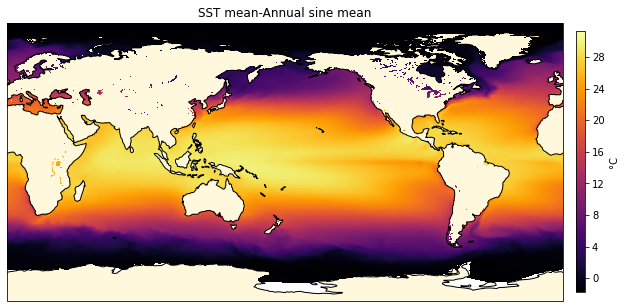

In [31]:
var=sst_mean-ann_sin

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')
cmap = plt.get_cmap('PiYG', 11)  
ax.coastlines()
pcm = ax.pcolormesh(var.lon, var.lat, var, cmap='inferno',transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=10))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST mean-Annual sine mean")

plt.show()


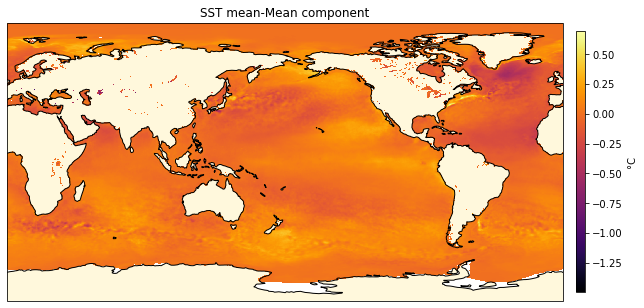

In [37]:
var=sst_mean-mean

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')
cmap = plt.get_cmap('PiYG', 11)  
ax.coastlines()
pcm = ax.pcolormesh(var.lon, var.lat, var, cmap='inferno',transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=10))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST mean-Mean component")

plt.show()


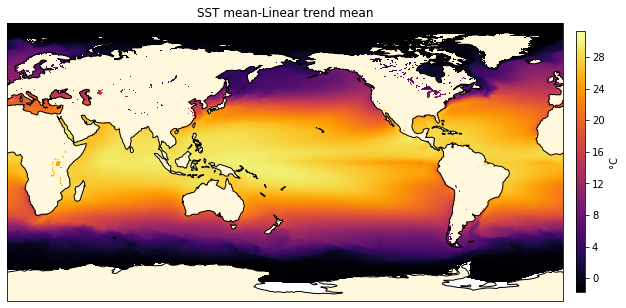

In [35]:
var=sst_mean-lin

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')
cmap = plt.get_cmap('PiYG', 11)  
ax.coastlines()
pcm = ax.pcolormesh(var.lon, var.lat, var, cmap='inferno',transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=10))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST mean-Linear trend mean")

plt.show()


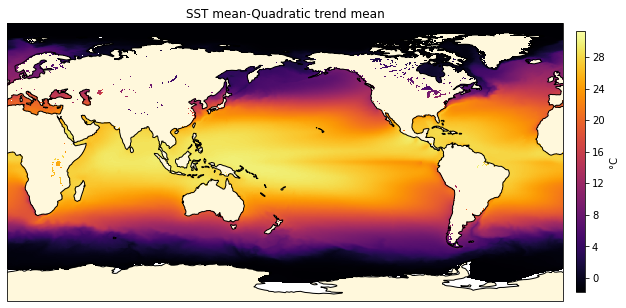

In [36]:
var=sst_mean-quad

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')
cmap = plt.get_cmap('PiYG', 11)  
ax.coastlines()
pcm = ax.pcolormesh(var.lon, var.lat, var, cmap='inferno',transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=10))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST mean-Quadratic trend mean")

plt.show()
